# NBA Market Share Analysis Group Project

Presentation order: Andrew/Blanca (Intro), Olga (Census, Google), Blanca (Valuation), Kevin, Andrew, Diamond

## Import Dependencies and API Keys

In [1]:
%matplotlib inline

import tweepy
import json
import gmaps
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
import warnings 
warnings.filterwarnings('ignore')
import requests
import time
import seaborn as sns
import scipy.stats as stats
import seaborn as sns

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from us import states
from pprint import pprint
from census import Census
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Import API Keys for Census, Google, and Twitter
from config import census_key , gkey , consumer_key , consumer_secret , access_token , access_token_secret

# <font color = red> Census vs Team Valuation Analysis </font>
***

In [2]:
# Census API Key
c = Census(census_key , year = 2013)

In [3]:
# "B01003_001E" Total Population
# "B19301_001E" Per capita income
# "B25058_001E" Average rent| Median contract rent
# "B19013_001E" Median household income
census_data = c.acs5.get(("B01003_001E", "B19301_001E", "B25058_001E", "B19013_001E" ), 
                         {'for': 'zip code tabulation area:*'})

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B19301_001E": "Per Capita Income",
                                      "B25058_001E": "Average Rent",
                                      "B19013_001E": "Median Household Income",
                                      "zip code tabulation area": "Zipcode"})

# Visualize
print(f"Census data ({len(census_pd)} lines) for the year 2016")
census_pd.head()

Census data (33120 lines) for the year 2016


,Population,Median Household Income,Per Capita Income,Average Rent,Zipcode
0,18450.0,12041.0,7380.0,285.0,00601
1,41302.0,15663.0,8463.0,319.0,00602
2,53683.0,15485.0,9176.0,252.0,00603
3,6591.0,15019.0,6383.0,230.0,00606
4,28963.0,16707.0,7892.0,334.0,00610


In [4]:
# Import zip codes from the official databese of US zip codes
zip_codes = pd.read_csv("Resources/free-zipcode-database-Primary.csv", dtype="object", encoding="utf-8")

# Visualize
zip_codes = zip_codes[["Zipcode", "City", "State"]]
zip_codes.head()

,Zipcode,City,State
0,00705,AIBONITO,PR
1,00610,ANASCO,PR
2,00611,ANGELES,PR
3,00612,ARECIBO,PR
4,00601,ADJUNTAS,PR


#### <font color = blue> Left Merge Census data with Zip Code DB to extract Census data for US Cities

In [5]:
# Merge the two data sets along zip code
census_data_complete = pd.merge(census_pd, zip_codes, how="left", on=["Zipcode"])

# Save the revised Data Frame as a csv
census_data_complete.to_csv("Output/CensusDataWithCityName.csv", encoding="utf-8", index=False)

# Visualize
census_data_complete.head()

,Population,Median Household Income,Per Capita Income,Average Rent,Zipcode,City,State
0,18450.0,12041.0,7380.0,285.0,00601,ADJUNTAS,PR
1,41302.0,15663.0,8463.0,319.0,00602,AGUADA,PR
2,53683.0,15485.0,9176.0,252.0,00603,AGUADILLA,PR
3,6591.0,15019.0,6383.0,230.0,00606,MARICAO,PR
4,28963.0,16707.0,7892.0,334.0,00610,ANASCO,PR


In [6]:
# Create ascending list of cities to add to a grouped DataFrame as after groupby['City'] we can not call fieald "City"
city_unique = census_data_complete['City'].unique()
city_list = np.sort(city_unique)
city_list

array(['AARONSBURG', 'ABBEVILLE', 'ABBOT', ..., 'ZURICH', 'ZWINGLE',
       'ZWOLLE'], dtype=object)

In [7]:
grouped_by_city = census_data_complete.groupby(census_data_complete['City'])

population = round(grouped_by_city['Population'].sum(),1)
per_cap_inc = round(grouped_by_city['Per Capita Income'].mean(),1)
rent = round(grouped_by_city['Average Rent'].mean(),1)
household_inc = round(grouped_by_city['Median Household Income'].mean(),1)

city_summary = pd.DataFrame({"Population": population, "Per Capita Income": per_cap_inc,
                            "Average Rent": rent, "City": city_list, "Median Household Income": household_inc})

# Save the revised Data Frame as a csv
city_summary.to_csv("Output/CitySummary.csv", encoding="utf-8", index=False)

print('Key values of USA Sensus grouped by City')
city_summary.head()

Key values of USA Sensus grouped by City


,Population,Per Capita Income,Average Rent,City,Median Household Income
City,,,,,
AARONSBURG,1303.0,19439.0,527.0,AARONSBURG,55947.0
ABBEVILLE,53225.0,18245.4,366.8,ABBEVILLE,40417.4
ABBOT,641.0,19646.0,438.0,ABBOT,36121.0
ABBOTSFORD,2830.0,24130.0,433.0,ABBOTSFORD,45609.0
ABBOTT,1021.0,26652.0,471.0,ABBOTT,57361.0


#### <font color = blue> Import Team Valuation Data

In [8]:
# Import NBA Teams Valuation Data
team_valuations = pd.read_csv("Resources/TeamValuations_oy.csv", dtype="object", encoding="utf-8")

# Team valuations 2017
team_valuations = team_valuations[["Item", "City", "State", "Code", "2017"]]
team_valuations.head()

,Item,City,State,Code,2017
0,New York Knicks,NEW YORK,New York,NY,3300
1,Los Angeles Lakers,LOS ANGELES,California,CA,3000
2,Golden State Warriors,SAN FRANCISCO,California,CA,2600
3,Chicago Bulls,CHICAGO,Illinois,IL,2500
4,Boston Celtics,BOSTON,Massachusetts,MA,2200


#### <font color = blue> Clean Census Data
> * There are zip codes that did not get populated with Census data - this resulted in distortion of results for Big Market cities like New York and Los Angeles. Some data points (e.g. Population) were more impacted than averaged data points (e.g. Per capita Income)
> * Toronto Data: manually updated because this is not in US Census (CAN)

In [9]:
# Merge NBA valuation data and Census data by City name

valuation = pd.merge(team_valuations, city_summary, how="left", on=["City"])

# Population Correction (source -  Wikipedia)
valuation.loc[0,'Population'] = 8622698
valuation.loc[1,'Population'] = 3999759
valuation.loc[4,'Population'] = 685094
valuation.loc[5,'Population'] = 3999760
valuation.loc[9,'Population'] = 396698
valuation.loc[10,'Population'] = 463347
valuation.loc[12,'Population'] = 2731571
valuation.loc[13,'Population'] = 1626078
valuation.loc[14,'Population'] = 501901
valuation.loc[15,'Population'] = 647805
valuation.loc[17,'Population'] = 693972
valuation.loc[18,'Population'] = 277173
valuation.loc[19,'Population'] = 200544
valuation.loc[21,'Population'] = 704621
valuation.loc[22,'Population'] = 486290
valuation.loc[26,'Population'] = 595351
valuation.loc[28,'Population'] = 422331

# Per Capita income corrections (incl Toronto)
valuation.loc[0,'Per Capita Income'] = 60991
valuation.loc[1,'Per Capita Income'] = 42042
valuation.loc[5,'Per Capita Income'] = 42042
valuation.loc[12,'Per Capita Income'] = 30089

valuation.loc[12,'Average Rent'] = 847

valuation.head(30)

,Item,City,State,Code,2017,Population,Per Capita Income,Average Rent,Median Household Income
0,New York Knicks,NEW YORK,New York,NY,3300,8622698.0,60991.0,1556.9,88988.9
1,Los Angeles Lakers,LOS ANGELES,California,CA,3000,3999759.0,42042.0,1055.7,46232.6
2,Golden State Warriors,SAN FRANCISCO,California,CA,2600,817539.0,56259.8,1480.8,80370.7
3,Chicago Bulls,CHICAGO,Illinois,IL,2500,2690705.0,37423.4,966.3,56087.7
4,Boston Celtics,BOSTON,Massachusetts,MA,2200,685094.0,55031.6,1320.8,67972.0
5,Los Angeles Clippers,LOS ANGELES,California,CA,2000,3999760.0,42042.0,1055.7,46232.6
6,Brooklyn Nets,BROOKLYN,New York,NY,1800,2600812.0,26437.3,1019.5,49367.5
7,Houston Rockets,HOUSTON,Texas,TX,1650,2990053.0,30449.1,736.8,53997.2
8,Dallas Mavericks,DALLAS,Texas,TX,1450,1427050.0,30534.3,749.2,50097.9
9,Cleveland Cavaliers,CLEVELAND,Ohio,OH,1200,396698.0,21467.1,561.2,39630.4


#### <font color = blue> Google Maps API Analysis for Teams

In [10]:
lat, lon = [], []
cities = valuation['City']
for city in cities:
    target_url = "https://maps.googleapis.com/maps/api/geocode/json?" \
    "address=%s&key=%s" % (city, gkey)
    geo_data = requests.get(target_url).json()
    lat.append(geo_data["results"][0]["geometry"]["location"]["lat"])
    lon.append(geo_data["results"][0]["geometry"]["location"]["lng"])

#### <font color = blue> Configure Gmaps API

In [11]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store 'Lat' and 'Lng' into  locations 
locations = pd.DataFrame({"Lat": lat, "Lon": lon})

team_val = valuation["2017"].astype(float)

#### <font color = blue> Generate Heatmap Analysis

In [12]:

# Create a Heatmap layer# Create 
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=team_val, 
                                 dissipating=False, max_intensity=1000,
                                 point_radius = 1.5)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 1000
heat_layer.point_radius = 1.5

# City layer
city_layer = gmaps.symbol_layer(locations, fill_color='rgba(100, 100, 0, 0.2)',
                                stroke_color='rgba(0, 0, 150, 0.5)', scale=2)

In [13]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(city_layer)

fig

Figure(layout=FigureLayout(height='420px'))

## Census Population vs Team Valuation

In [14]:
# With NYC
x = valuation['Population']
y = valuation['2017'].astype(float)

x1 = valuation['Per Capita Income']
y1 = valuation['2017'].astype(float)

x2 = valuation['Average Rent']
y2 = valuation['2017'].astype(float)

# Clean data from NYC
valuation_wo_nyc = valuation.drop(valuation.index[0])

x3 = valuation_wo_nyc['Per Capita Income']
y3 = valuation_wo_nyc['2017'].astype(float)

x4 = valuation_wo_nyc['Average Rent']
y4 = valuation_wo_nyc['2017'].astype(float)

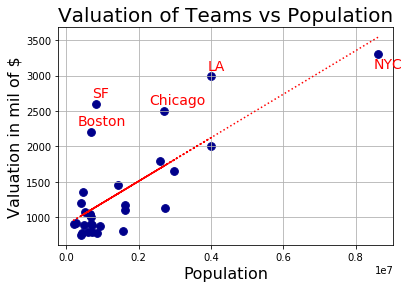

In [15]:
# Valuation vs Population# Valua 

plt.scatter(x, y, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r:")

# Add other captions on plot
plt.title(f"Valuation of Teams vs Population", size = 20)
plt.xlabel("Population", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(700000, 2700, "SF", fontsize=14, color = "red")
plt.text(2300000, 2600, "Chicago", fontsize=14, color = "red")
plt.text(3900000, 3070, "LA", fontsize=14, color = "red")
plt.text(300000, 2300, "Boston", fontsize=14, color = "red")
plt.text(8500000, 3100, "NYC", fontsize=14, color = "red")

plt.grid()

## <font color = Green> Results: City Population vs Team Valuation Analysis

> ### We can conclude that there is no visible correlation between Population and team valuation. 
> ### The Scatter Plot trend line is mostly driven by New York - if this outlier is excluded from calculations, there is no visible correlation. This makes sense because densely populated cities with low income population are less likely to spend disposable income on tickets, gear, and other league merchandise. 

## Census Per Capita Income vs Team Valuation

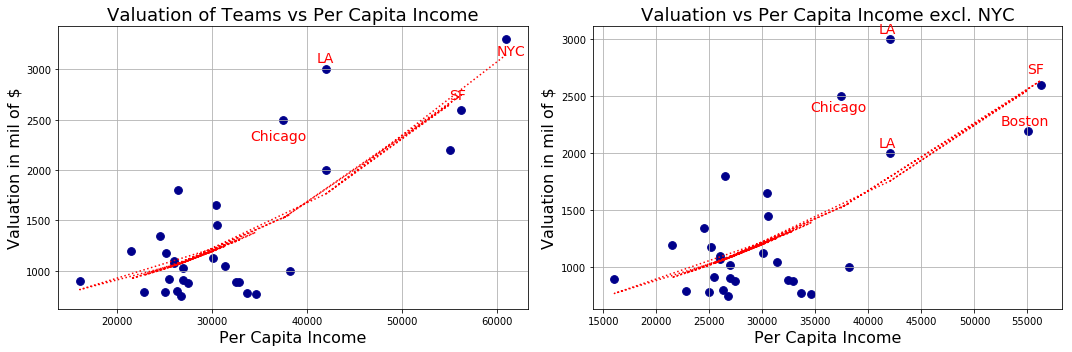

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

# All cities

plt.subplot(1,2,1)
plt.scatter(x1, y1, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z1 = np.polyfit(x1, y1, 2)
p1 = np.poly1d(z1)
plt.plot(x1,p1(x1),"r:")

# Add other captions on plot
plt.title(f"Valuation of Teams vs Per Capita Income", size = 18)
plt.xlabel("Per Capita Income", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(60000, 3140, "NYC", fontsize=14, color = "red")
plt.text(41000, 3070, "LA", fontsize=14, color = "red")
plt.text(55000, 2700, "SF", fontsize=14, color = "red")
plt.text(34000, 2300, "Chicago", fontsize=14, color = "red")
plt.grid()

# Without NYC

plt.subplot(1,2,2)
plt.scatter(x3, y3, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z3 = np.polyfit(x3, y3, 2)
p3 = np.poly1d(z3)
plt.plot(x3,p3(x3),"r:")

plt.title(f"Valuation vs Per Capita Income excl. NYC", size = 18)
plt.xlabel("Per Capita Income", size = 16)
plt.ylabel("Valuation in mil of $", size = 16)
plt.text(41000, 3050, "LA", fontsize=14, color = "red")
plt.text(41000, 2050, "LA", fontsize=14, color = "red")
plt.text(55000, 2700, "SF", fontsize=14, color = "red")
plt.text(34500, 2370, "Chicago", fontsize=14, color = "red")
plt.text(52500, 2250, "Boston", fontsize=14, color = "red")
plt.grid()

plt.tight_layout()

## <font color = Green> Results: City Per Capita Income vs Team Valuation Analysis

> ### There are visible tendencies displayed in these scatter plots but nothing that definitively shows correlation between the two parameters. 
> ### This could be a result of the "per capita" aspect of the data - it includes children and other household dependents who don't partake in the spending budget.
> ### Excluding New York: we can see a breakout of two groups - SF, LA, Boston, Chicago and the rest of the NBA teams. 

## Census Average Rent vs Team Valuation

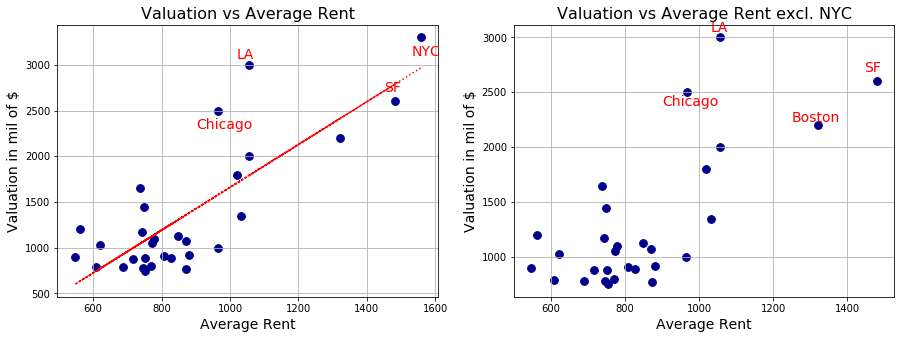

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

# Average Rent - All cities
plt.subplot(1,2,1)
plt.scatter(x2, y2, marker="o", s=60, facecolors = "darkblue")

# Add trendline
z2 = np.polyfit(x2, y2, 1)
p2 = np.poly1d(z2)
plt.plot(x2,p2(x2),"r:")

# Add other captions on plot
plt.title(f"Valuation vs Average Rent", size = 16)
plt.xlabel("Average Rent", size = 14)
plt.ylabel("Valuation in mil of $", size = 14)
plt.text(1530, 3100, "NYC", fontsize=14, color = "red")
plt.text(1020, 3070, "LA", fontsize=14, color = "red")
plt.text(1450, 2700, "SF", fontsize=14, color = "red")
plt.text(900, 2300, "Chicago", fontsize=14, color = "red")
plt.grid()

# Without NYC

plt.subplot(1,2,2)
plt.scatter(x4, y4, marker="o", s=60, facecolors = "darkblue")

# Add trendline
#z4 = np.polyfit(x4, y4, 2)
#p4 = np.poly1d(z4)
#plt.plot(x4,p4(x4),"r:")

# Add other captions on plot
plt.title(f"Valuation vs Average Rent excl. NYC", size = 16)
plt.xlabel("Average Rent", size = 14)
plt.ylabel("Valuation in mil of $", size = 14)
plt.text(1030, 3050, "LA", fontsize=14, color = "red")
plt.text(1445, 2690, "SF", fontsize=14, color = "red")
plt.text(900, 2380, "Chicago", fontsize=14, color = "red")
plt.text(1250, 2230, "Boston", fontsize=14, color = "red")
plt.grid()

## <font color = Green> Results: City Average Rent vs Team Valuation Analysis

> ### The scatter plots display the median contract rent and the team valuations. It can be seen that the cities with higher median rents tend to be more willing to spend disposable income on NBA tickets, merchandise, and other factors that impact a team's valuation.

# <font color = red> Market Rank vs Team Valuation Analysis </font>
***

In [18]:
df = pd.read_csv("Historical_Valuations_TB.csv")
df.head()
df.dtypes

Market_Size     object
Market_Rank      int64
Item            object
Year             int64
Valuation      float64
dtype: object

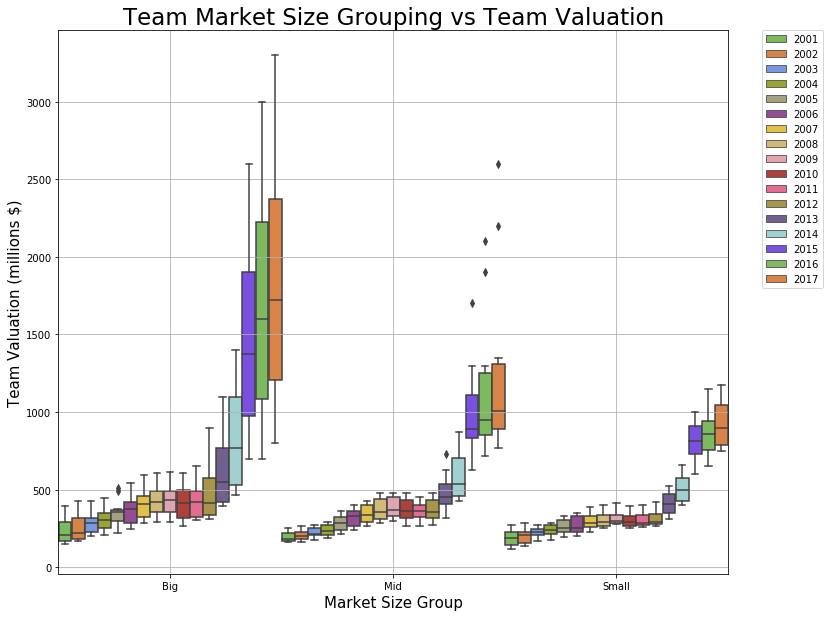

In [19]:
#df.boxplot(["Valuation"], by="Market_Size", figsize=(20, 10))

pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A8A878',  # Normal
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#E0C068',  # Ground
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#B8A038',  # Rock
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
#legend = ["2001", "2002", "2003", "2004", "2005","2006","2007", "2008", "2009","2010","2011", "2012", "2013","2014","2015","2016","2017"]
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 10)
bplot = sns.boxplot(y='Valuation', x='Market_Size', 
                 data=df, 
                 width=1,
                 hue="Year", palette = pkmn_type_colors)
#plt.figure(figsize=(15,8))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.grid(True, which='both')
plt.xlabel("Market Size Group" , size = 15)
plt.ylabel("Team Valuation (millions $)" , size = 15)
plt.title("Team Market Size Grouping vs Team Valuation" , size = 23)

plt.savefig('Valuation_Histogram.png')

In [20]:
df_market = pd.pivot_table(df,index=["Market_Size", "Year"],values=["Valuation"],aggfunc=np.mean)
df_market.head(20)
#pd.pivot_table(df,index=["Manager","Rep"],values=["Price"],aggfunc=np.sum)

Valuation
Market_Size Year           
Big         2001      239.6
            2002      259.6
            2003      292.2
            2004      312.3
            2005      354.7
            2006      377.2
            2007      415.7
            2008      432.4
            2009      434.1
            2010      422.7
            2011      435.8
            2012      493.5
            2013      633.3
            2014      831.9
            2015     1512.0
            2016     1724.0
            2017     1862.5
Mid         2001      197.1
            2002      207.8
            2003      227.7

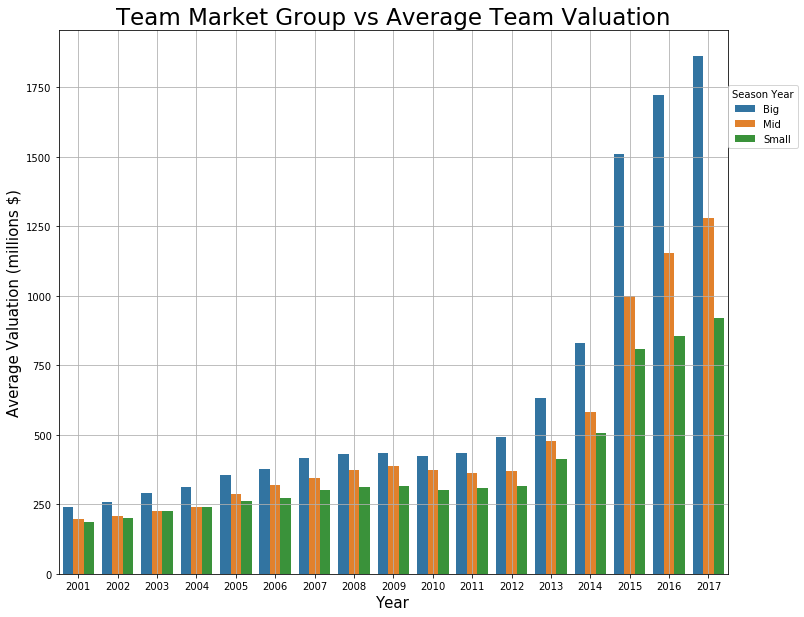

In [21]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 10)
sns.barplot(x="Year", y="Valuation", data=df_market.reset_index(), hue="Market_Size")
plt.xlabel("Year" , size = 15)
plt.ylabel("Average Valuation (millions $)" , size = 15)
plt.title("Team Market Group vs Average Team Valuation" , size = 23)
plt.legend(bbox_to_anchor = (1 , .9) , loc = 2 , borderaxespad = 0. , title = "Season Year")
ax.grid(True , which = "Both")
#sns.barplot(x='FinYear', y='Amount', data=invYr.reset_index())
#sns.barplot(x=invYr.index, y=invYr.Amount)
#ns.barplot(x="alcohol", y="abbrev", data=crashes,
           # label="Alcohol-involved", color="b")

In [22]:
df_team_5_big = df.loc[df['Item'].isin(['Golden State Warriors','New York Knicks','San Antonio Spurs','Boston Celtics','Los Angeles Lakers','Houston Rockets','Cleveland Cavaliers'])]
df_team_5_big2 = df_team_5_big[(df_team_5_big['Year']>=2012)] 

df_team_5_big2
df_team_5_big2.head()

,Market_Size,Market_Rank,Item,Year,Valuation
11,Big,1,New York Knicks,2012,780.0
12,Big,1,New York Knicks,2013,1100.0
13,Big,1,New York Knicks,2014,1400.0
14,Big,1,New York Knicks,2015,2500.0
15,Big,1,New York Knicks,2016,3000.0


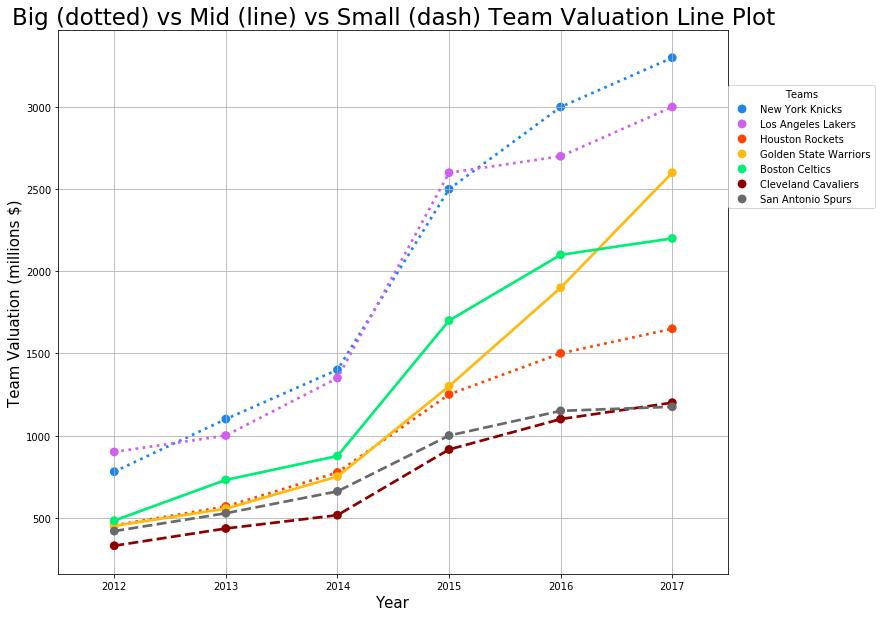

In [23]:
fig, ax = plt.subplots()

fig.set_size_inches(12, 10)
palette = ['#1C86EE', '#D15FEE', '#FF4500', '#FFB90F',  '#00EE76','#8B0000', '#696969']
ax = sns.pointplot(x="Year", y="Valuation",hue="Item", data=df_team_5_big2, linestyles=[":", ":",":","-", "-","--","--"], palette=palette)

plt.xlabel("Year" , size = 15)
plt.ylabel("Team Valuation (millions $)" , size = 15)
plt.title("Big (dotted) vs Mid (line) vs Small (dash) Team Valuation Line Plot" , size = 23)
plt.legend(bbox_to_anchor = (1 , .9) , loc = 2 , borderaxespad = 0. , title = "Teams")
ax.grid(True , which = "Both")

## Import Files

#### <font color = blue> Import Original Historical Team Valuation XLS File

In [24]:
FilePath = "Resources/TeamValuations_orig.csv"

TeamVal_orig_DF = pd.read_csv(FilePath)

# print(f'Col Types:\n{TeamVal_orig_DF.dtypes}')

#### <font color = blue> Import Denormalized CSV File generated using Tableu plug-in

In [25]:
FilePath = "Resources/TeamValuations_denormalized_for_BoxPlot.csv"

TeamVal_deNorm_DF = pd.read_csv(FilePath)

# print(f'Col Types:\n{TeamVal_deNorm_DF.dtypes}')

#### <font color = blue> Clean Data

In [26]:
TeamVal_orig_DF.fillna(0 , inplace = True)
TeamVal_deNorm_DF.fillna(0 , inplace = True)

In [27]:
TeamVal_orig_DF.head(10)

,Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New York Knicks,395.0,392.0,398.0,401.0,494,543,592,608,613,586,655,780,1100,1400,2500,3000,3300
1,Los Angeles Lakers,390.0,426.0,426.0,447.0,510,529,568,560,584,607,643,900,1000,1350,2600,2700,3000
2,Golden State Warriors,168.0,166.0,176.0,188.0,228,243,267,309,335,315,363,450,555,750,1300,1900,2600
3,Chicago Bulls,314.0,329.0,323.0,356.0,368,409,461,500,504,511,511,600,800,1200,2000,2300,2500
4,Boston Celtics,212.0,218.0,274.0,290.0,334,353,367,391,447,433,452,482,730,875,1700,2100,2200
5,Los Angeles Clippers,154.0,170.0,205.0,208.0,224,248,285,294,297,295,305,324,430,575,1600,2000,2000
6,Brooklyn Nets,179.0,169.0,218.0,244.0,296,271,325,338,295,269,312,357,530,780,1500,1700,1800
7,Houston Rockets,206.0,234.0,255.0,278.0,369,422,439,462,469,470,443,453,568,775,1250,1500,1650
8,Dallas Mavericks,167.0,211.0,304.0,338.0,374,403,463,461,466,446,438,497,685,765,1150,1400,1450
9,Cleveland Cavaliers,185.0,202.0,222.0,258.0,298,356,380,455,477,476,355,329,434,515,915,1100,1200


In [28]:
TeamVal_deNorm_DF.tail(10)

,Market_Size,Market_Rank,Item,Year,Valuation
500,Small,30,New Orleans Pelicans,2008,272.0
501,Small,30,New Orleans Pelicans,2009,285.0
502,Small,30,New Orleans Pelicans,2010,267.0
503,Small,30,New Orleans Pelicans,2011,280.0
504,Small,30,New Orleans Pelicans,2012,285.0
505,Small,30,New Orleans Pelicans,2013,340.0
506,Small,30,New Orleans Pelicans,2014,420.0
507,Small,30,New Orleans Pelicans,2015,650.0
508,Small,30,New Orleans Pelicans,2016,650.0
509,Small,30,New Orleans Pelicans,2017,750.0


In [29]:
# TeamVal_deNorm_DF.head(10)

In [30]:
#####################################################
# Extract Valuation values for each Market Size group
#####################################################

Big_Val   = TeamVal_deNorm_DF[TeamVal_deNorm_DF["Market_Size"] == "Big"]["Valuation"]

Mid_Val   = TeamVal_deNorm_DF[TeamVal_deNorm_DF["Market_Size"] == "Mid"]["Valuation"]

Small_Val = TeamVal_deNorm_DF[TeamVal_deNorm_DF["Market_Size"] == "Small"]["Valuation"]

### <font color = blue> Run ANOVA Test:
* $H_0$: Team valuation means across the different Market Ranks (Big, Med, Small) are NOT statistically different.
* $H$: Team valuation means across the different Market Ranks (Big, Med, Small) are statistically diffent - market size matters.

In [31]:
########################
# Perform a 1-way ANOVA
########################

ANOVA_Test = stats.f_oneway(Big_Val , Mid_Val , Small_Val)
ANOVA_Test

F_onewayResult(statistic=14.916928984438803, pvalue=5.071113482370098e-07)

### <font color = blue> Generate Time Series Line Plot of Team Valuations

In [32]:
Trans_TeamValuation_DF = TeamVal_orig_DF.T
# Trans_TeamValuation_DF.head(5)

In [33]:
# Transpose Data Frame to make Year Columns and Team Rows

Trans_TeamValuation_DF.columns = Trans_TeamValuation_DF.iloc[0]
Trans_TeamValuation_DF = Trans_TeamValuation_DF.reindex(Trans_TeamValuation_DF.index.drop("Year"))
Trans_TeamValuation_DF.columns = Trans_TeamValuation_DF.columns.values
Trans_TeamValuation_DF.index = [int(x) for x in Trans_TeamValuation_DF.index.values]

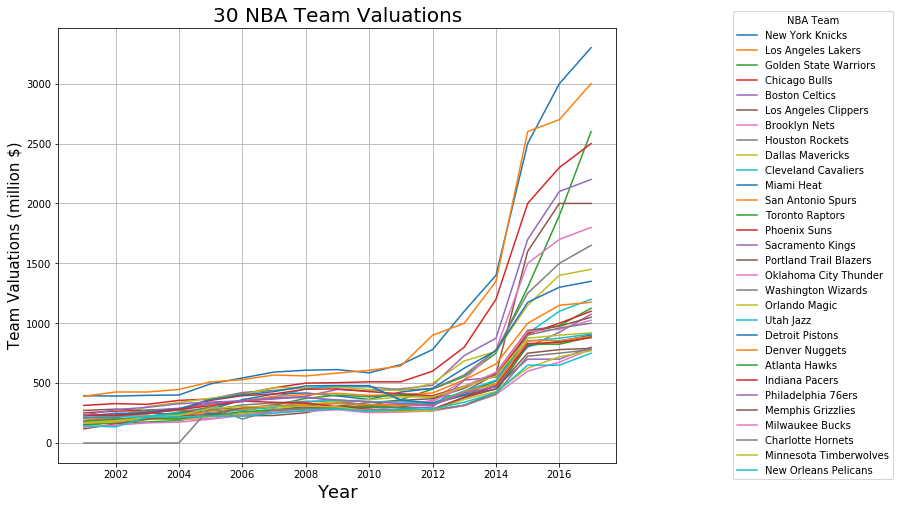

In [34]:
# Plot the results
%matplotlib inline
Trans_TeamValuation_DF.plot()
plt.grid()

plt.legend(loc = "center left" , bbox_to_anchor = (1.2, .5) , title = "NBA Team")
plt.title("30 NBA Team Valuations" , size = 20)
plt.xlabel("Year", size = 18)
plt.ylabel("Team Valuations (million $)" , size = 15)
plt.gcf().set_size_inches(10 , 8 , forward = True)

## <font color = Green> Results: Market Rank vs Team Valuation Analysis

> ### ANOVA Result:  p-value = .000000507 
>#### Interpretation: 
<= .05: Reject Null Hypothesis H0
>>Team valuation means across the different Market Ranks (Big, Med, Small) are statistically different.

# <font color = red> Market Size vs Team Attendance Analysis </font>
***

In [35]:
df = pd.read_csv("Historical_Attendance.csv")
df.head()
df.dtypes

Market_Size     object
Market_Rank      int64
Item            object
Year             int64
Attendance     float64
dtype: object

In [36]:
dfyr = df[(df['Year'] >= 2013)]

dfyr.head()

,Market_Size,Market_Rank,Item,Year,Attendance
12,Big,1,New York Knicks,2013,780353.0
13,Big,1,New York Knicks,2014,812292.0
14,Big,1,New York Knicks,2015,812292.0
15,Big,1,New York Knicks,2016,812292.0
16,Big,1,New York Knicks,2017,810741.0


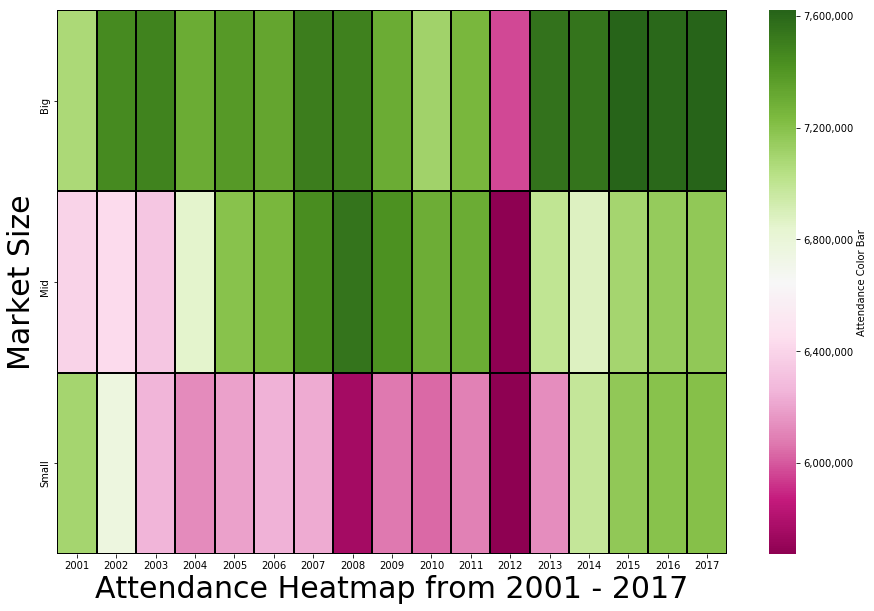

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
attendance = pd.pivot_table(df,index=["Market_Size", "Year"],values=["Attendance"], aggfunc=np.sum)
attendance.head()
attendance_df = attendance.unstack()
attendance_df.head()
comma_fmt = FuncFormatter(lambda Attendance, p: format(int(Attendance), ','))
ax = sns.heatmap(attendance_df, cmap="PiYG",linewidths=1 ,robust=True,linecolor="black", cbar_kws={'label': 'Attendance Color Bar','format':comma_fmt}, annot_kws={"size": 20},xticklabels=("2001", "2002", "2003", "2004", "2005","2006","2007", "2008", "2009","2010","2011", "2012", "2013","2014","2015","2016","2017" )) 

ax.set( ylabel="Market Size",
       xlabel="Attendance Heatmap from 2001 - 2017")

ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(30)
plt.savefig('Attendance_Heatmap.png')

In [38]:
df_team_5_big = df.loc[df['Item'].isin(['Golden State Warriors','New York Knicks','San Antonio Spurs','Boston Celtics','Los Angeles Lakers','Houston Rockets','Cleveland Cavaliers'])]
df_team_5_big2 = df_team_5_big[(df_team_5_big['Year']>=2012)] 

df_team_5_big2
df_team_5_big2.head()

,Market_Size,Market_Rank,Item,Year,Attendance
11,Big,1,New York Knicks,2012,652179.0
12,Big,1,New York Knicks,2013,780353.0
13,Big,1,New York Knicks,2014,812292.0
14,Big,1,New York Knicks,2015,812292.0
15,Big,1,New York Knicks,2016,812292.0


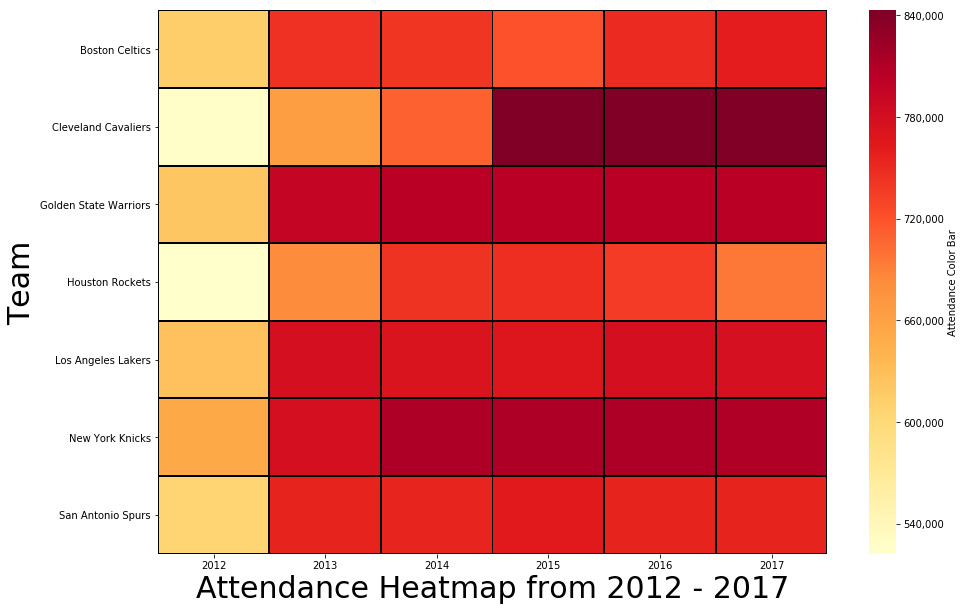

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

attendance_team = pd.pivot_table(df_team_5_big2,index=["Item", "Year"],values=["Attendance"], aggfunc=np.sum)
attendance_team.head()
attendance_team_df = attendance_team.unstack()
comma_fmt = FuncFormatter(lambda Attendance, p: format(int(Attendance), ','))
ax = sns.heatmap(attendance_team_df, cmap="YlOrRd",linewidths=1 ,robust=True,linecolor="black", cbar_kws={'label': 'Attendance Color Bar','format':comma_fmt}, annot_kws={"size": 20},xticklabels=( "2012", "2013","2014","2015","2016","2017" )) 

ax.set( ylabel="Team",
       xlabel="Attendance Heatmap from 2012 - 2017")

ax.yaxis.label.set_size(30)
ax.xaxis.label.set_size(30)
plt.savefig('Attendance_team_Heatmap.png')

# <font color = red> Team Market Ranks vs Twitter Popularity Analysis </font>
***

### <font color = blue> Extract Twitter Follower Counts for each team and Run Vader Analysis

In [40]:
################
# Import File
################
FilePath = "Resources/NBA_TeamMarketSize_orig.xlsx"

NBA_MarketRank_DF = pd.read_excel(FilePath)

In [41]:
###################################
# Setup Tweepy API Authentication
###################################
Authorization = tweepy.OAuthHandler(consumer_key , consumer_secret)
Authorization.set_access_token(access_token , access_token_secret)
apiRequests = tweepy.API(Authorization , parser = tweepy.parsers.JSONParser())

In [42]:
####################
# Initialize Vader
####################
VaderSentimentAnalyzer = SentimentIntensityAnalyzer()

In [43]:
TeamNameList = []
FollowerCountList = []

CompoundList = []
PositiveList = []
NegativeList = []
NeutralList = []
TeamNameList_Sentiment = []

In [44]:
##########################################################
# Extract Twitter Followers and Twitter Sentiments Scores
##########################################################
# Target User
target_users = ["Raptors" , "warriors" , "nuggets" , "okcthunder" , "PelicansNBA" , "dallasmavs" , \
                "Hornets" , "Lakers" , "nyknicks" , "Timberwolves" , "LAClippers" , "OrlandoMagic" , \
                "Pacers" , "cavs" , "HoustonRockets" , "BrooklynNets" , "Suns" , "spurs" , "utahjazz" , \
                "celtics" , "ATLHawks" , "DetroitPistons" , "chicagobulls" , "sixers" , "Bucks" , \
                "WashWizards" , "MiamiHEAT" , "memgrizz" , "trailblazers" , "SacramentoKings"
               ]

# Loop through the Target Users
# x: News Outlet
for team in target_users:
    # Get tweets from the home feed
    UserTweets = apiRequests.user_timeline(team)

    # Get follower count
    TeamName = UserTweets[0]["user"]["name"]
    FollowerCount = UserTweets[0]["user"]["followers_count"]
    TeamNameList.append(TeamName)
    FollowerCountList.append(FollowerCount)
    
    # Retrieve the last 100 Tweets for Target User
    # y: page
    for page in range(5): 

        # Get tweets from the home feed
        UserTweets_2 = apiRequests.user_timeline(team , page = page)
        
        # Loop through tweets
        # z: tweet
        for tweet in UserTweets_2: 
            
            
#           # Run Vader Analysis on each tweet
            CompoundScore = VaderSentimentAnalyzer.polarity_scores(tweet["text"])["compound"]
            PositiveScore = VaderSentimentAnalyzer.polarity_scores(tweet["text"])["pos"]
            NegativeScore = VaderSentimentAnalyzer.polarity_scores(tweet["text"])["neg"]
            NeutralScore = VaderSentimentAnalyzer.polarity_scores(tweet["text"])["neu"] 
            
#             print(NeutralScore)

            # Append to the Sentiment list           

            CompoundList.append(CompoundScore)
            PositiveList.append(PositiveScore)
            NegativeList.append(NegativeScore)
            NeutralList.append(NeutralScore)
            TeamNameList_Sentiment.append(TeamName)
#             print(f'{tweet["user"]["name"]}{CompoundScore}{PositiveScore}{NegativeScore}{NeutralScore}')

In [45]:
# print(len(CompoundList))
# print(len(PositiveList))
# print(len(NegativeList))
# print(len(NeutralList))
# print(len(TeamNameList_Sentiment))

### <font color = blue> Run Two ANOVA Tests:
* $H_0$: Teams in the Big Markets do NOT have more followers or higher sentiment scores than the Smaller Markets.
* $H$: Teams in the Big Markets have more followers or higher sentiment score than the Smaller Markets.

In [46]:
###################################
# Generate Data Frames from Lists
###################################
TwitterSentiments_DF = pd.DataFrame({"Team_Name"       : TeamNameList_Sentiment
                                    ,"Positive Score"  : PositiveList
                                    ,"Negative Score"  : NegativeList                           
                                    ,"Neutral Score"   : NeutralList
                                    ,"Compound Score"  : CompoundList
                                    })

Twitter_DF = pd.DataFrame({"Team_Name"              : TeamNameList
                          ,"Twitter Follower Count" : FollowerCountList
                          })

In [47]:
##############################################
# Lower Case conversion to merge on Team_Name
##############################################
Twitter_DF["Team_Name"] = Twitter_DF["Team_Name"].str.lower()
TwitterSentiments_DF["Team_Name"] = TwitterSentiments_DF["Team_Name"].str.lower()
NBA_MarketRank_DF["Team_Name"] = NBA_MarketRank_DF["Team_Name"].str.lower()

In [48]:
Twitter_DF["Team_Name"].replace("okc thunder" , "oklahoma city thunder" , inplace = True)
Twitter_DF["Team_Name"].replace("timberwolves" , "minnesota timberwolves" , inplace = True)
Twitter_DF["Team_Name"].replace("la clippers" , "los angeles clippers" , inplace = True)
Twitter_DF["Team_Name"].replace("trail blazers" , "portland trailblazers" , inplace = True)

TwitterSentiments_DF["Team_Name"].replace("okc thunder" , "oklahoma city thunder" , inplace = True)
TwitterSentiments_DF["Team_Name"].replace("timberwolves" , "minnesota timberwolves" , inplace = True)
TwitterSentiments_DF["Team_Name"].replace("la clippers" , "los angeles clippers" , inplace = True)
TwitterSentiments_DF["Team_Name"].replace("trail blazers" , "portland trailblazers" , inplace = True)

In [49]:
####################
# Join Data Frames
####################
Twitter_DF = Twitter_DF.merge(NBA_MarketRank_DF, left_on='Team_Name', right_on='Team_Name', how='left')

TwitterSentiments_DF = TwitterSentiments_DF.merge(Twitter_DF, left_on='Team_Name', right_on='Team_Name', how='left')

In [50]:
Big_DF = TwitterSentiments_DF.loc[TwitterSentiments_DF["Market_Size_Rank_Gp"] == "Big"]
Mid_DF = TwitterSentiments_DF.loc[TwitterSentiments_DF["Market_Size_Rank_Gp"] == "Mid"]
Small_DF = TwitterSentiments_DF.loc[TwitterSentiments_DF["Market_Size_Rank_Gp"] == "Small"]

In [51]:
Big_Followers = Big_DF["Twitter Follower Count"]/1000000
Mid_Followers = Mid_DF["Twitter Follower Count"]/1000000
Small_Followers = Small_DF["Twitter Follower Count"]/1000000

Big_CompoundScore = Big_DF["Compound Score"]
Mid_CompoundScore = Mid_DF["Compound Score"]
Small_CompoundScore = Small_DF["Compound Score"]

In [52]:
########################
# Perform a 1-way ANOVA: Followers VS Group Rank
########################
ANOVA_Test = stats.f_oneway(Big_Followers , Mid_Followers , Small_Followers)
ANOVA_Test

F_onewayResult(statistic=137.11106148309105, pvalue=1.0521977841608128e-57)

In [53]:
########################
# Perform a 1-way ANOVA: Compound Vader Scores VS Group Rank
########################
ANOVA_Test = stats.f_oneway(Big_CompoundScore , Mid_CompoundScore , Small_CompoundScore)
ANOVA_Test

F_onewayResult(statistic=0.9450840177791847, pvalue=0.38876271172003773)

## <font color = Green> Results: Market Rank vs Twitter Popularity Analysis

> ### Follower Count ANOVA Result:  p-value = 4.457795556035537 x 10^-12 
>#### Interpretation: 
$<=$ .05:  Reject Null Hypothesis H0
>>Teams in the Big markets tend to have more followers than the teams in Smaller markets.

> ### Tweet Polarity ANOVA Result:  p-value = 0.29302671729991175
>#### Interpretation: 
> $>$.05:  Accept Null Hypothesis H0
>>Teams in the Big markets don't have more favoriable social media sentiment scores than the teams in Smaller markets.

### <font color = blue> Generate Scatter Plot to verify ANOVA Tests

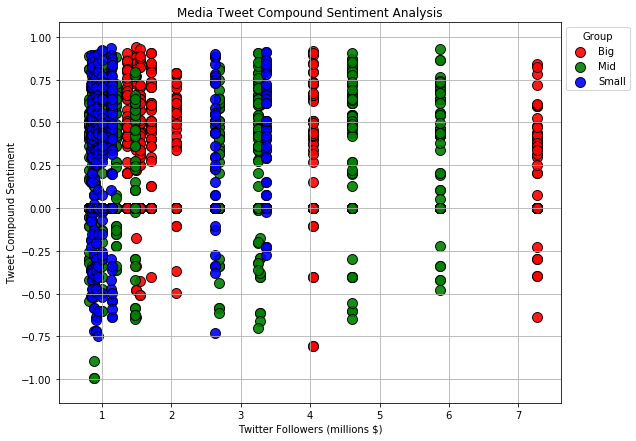

In [54]:
#############################
# Generate a Scatter Plot
#############################
plt.scatter(Big_Followers , Big_CompoundScore , color = "red" ,\
            edgecolor = "black" , s = 100 , alpha = .9 , label = "Big")
plt.scatter(Mid_Followers , Mid_CompoundScore , color = "green" ,\
            edgecolor = "black" , s = 100 , alpha = .9 , label = "Mid")
plt.scatter(Small_Followers , Small_CompoundScore , color = "blue" ,\
            edgecolor = "black" , s = 100 , alpha = .9 , label = "Small")

plt.title("Media Tweet Compound Sentiment Analysis")
plt.xlabel("Twitter Followers (millions $)")
plt.ylabel("Tweet Compound Sentiment")
plt.legend(bbox_to_anchor = (1, 1) , title = "Group")
plt.gcf().set_size_inches(9 , 7 , forward = True)
plt.grid()

# <font color = red> Market Rank vs Team Wins/Losses Analysis </font>
***

In [55]:
#read csv and create dataframe
records_df = pd.read_csv("GameResults.csv", delimiter = '\t')

In [56]:
#show the dataframe
records_df.head()

,Type,D,M,Y,Season,Winning League,Winning Team,Losing League,Losing Team,Winner Score,Loser Score,OT,Country,City,Attend.
0,Regular Season,1,1,2007,(2006-07),NBA,Boston Celtics,NBA,Portland Trail Blazers,89,81,NaN,NaN,NaN,NaN
1,Regular Season,1,1,2007,(2006-07),NBA,Minnesota Timberwolves,NBA,Charlotte Hornets,102,96,NaN,NaN,NaN,NaN
2,Regular Season,2,1,2007,(2006-07),NBA,Cleveland Cavaliers,NBA,San Antonio Spurs,82,78,NaN,NaN,NaN,NaN
3,Regular Season,2,1,2007,(2006-07),NBA,Dallas Mavericks,NBA,Oklahoma City Thunder,112,88,NaN,NaN,NaN,NaN
4,Regular Season,2,1,2007,(2006-07),NBA,Golden State Warriors,NBA,New Orleans Pelicans,97,89,NaN,NaN,NaN,NaN


In [57]:
#get the value count of the "Winning Team" column to get win#
records_df["Winning Team"].value_counts()

#create a new data frame with the count of each team's wins
team_wins = pd.DataFrame(records_df["Winning Team"].value_counts().reset_index())
team_wins.columns = ['Teams', 'Wins']

#get the value count of the "Losing Team" column to get loss#
records_df["Losing Team"].value_counts()

#create a new data frame with the count of each team's losses
team_losses = pd.DataFrame(records_df["Losing Team"].value_counts().reset_index())
team_losses.columns = ['Teams', 'Losses']

#merge the 2 dataframe on "Teams" to get total records
team_records_df = pd.merge(team_wins, team_losses, on = "Teams")

In [58]:
#calculate the win% and add it as a new column of the dataframe
team_records_df["Win%"] = (team_records_df["Wins"] / (team_records_df["Wins"]+team_records_df["Losses"]))*100

In [59]:
#create list of teams for each market size
big_market = ["New York Knicks", "Brooklyn Nets", "Los Angeles Lakers", "Los Angeles Clippers", "Chicago Bulls", "Toronto Raptors", "Philadelphia 76ers", "Dallas Mavericks", "Washington Wizards", "Houston Rockets"]
mid_market = ["Golden State Warriors", "Atlanta Hawks", "Boston Celtics", "Phoenix Suns", "Detroit Pistons", "Minnesota Timberwolves", "Miami Heat", "Denver Nuggets (2)", "Orlando Magic", "Cleveland Cavaliers"]
small_market = ["Sacramento Kings", "Portland Trail Blazers", "Charlotte Hornets", "Indiana Pacers", "Utah Jazz", "San Antonio Spurs", "Milwaukee Bucks", "Oklahoma City Thunder", "Memphis Grizzlies", "New Orleans Pelicans"]

In [60]:
#create a function that returns a value for market size based on which market the team falls in
def MarketSize (row):
    if row['Teams'] in big_market:
        return "Big"
    if row["Teams"] in mid_market:
        return "Mid"
    if row["Teams"] in small_market:
        return "Small"
    
#create a new column for the dataframe based on the value returned from the function
team_records_df["Market Size"] = team_records_df.apply(lambda row: MarketSize (row), axis=1)

#sort the dataframe by market size
team_records_df = team_records_df.sort_values(by=["Market Size"])

#check the dataframe
team_records_df

,Teams,Wins,Losses,Win%,Market Size
14,Los Angeles Clippers,482,466,50.843882,Big
27,Philadelphia 76ers,349,573,37.852495,Big
26,Brooklyn Nets,355,573,38.254310,Big
24,New York Knicks,378,532,41.538462,Big
4,Houston Rockets,569,392,59.209157,Big
22,Washington Wizards,406,531,43.329776,Big
6,Dallas Mavericks,551,411,57.276507,Big
8,Chicago Bulls,531,439,54.742268,Big
11,Los Angeles Lakers,502,486,50.809717,Big
17,Toronto Raptors,475,466,50.478215,Big


In [61]:
#create new data frame for all teams, win%, and market size
teams_perc = team_records_df[["Teams", "Win%", "Market Size"]]

#display and check the dataframe
teams_perc.head()

,Teams,Win%,Market Size
14,Los Angeles Clippers,50.843882,Big
27,Philadelphia 76ers,37.852495,Big
26,Brooklyn Nets,38.254310,Big
24,New York Knicks,41.538462,Big
4,Houston Rockets,59.209157,Big


Text(0,0.5,'Winning Percentage (%)')

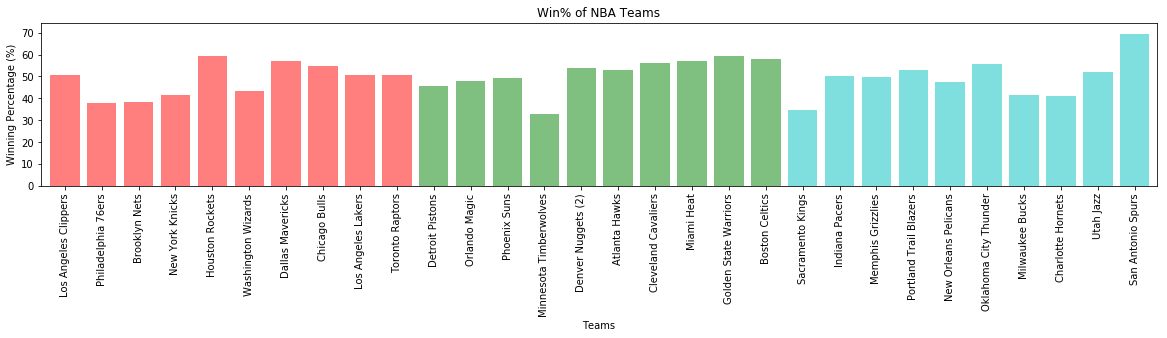

In [62]:
#set x_axis and tick_locations
x_axis = np.arange(len(teams_perc))
tick_locations = [value+0.4 for value in x_axis]

#create color map for the 3 groups
colors = teams_perc['Market Size'].map({'Big':'r', 'Mid':'g', 'Small':'c'})

#plot the graph
plt.figure(figsize=(20,3))
plt.bar(x_axis, teams_perc["Win%"], color=colors, alpha=0.5, align="edge")

#set team names at the tick locations
plt.xticks(tick_locations, teams_perc["Teams"], rotation="vertical")

#set the plot x-limit and y-limit
plt.xlim(-.25,30)
plt.ylim(0, max(teams_perc["Win%"])+5)

#set the plot title and x and y labels
plt.title("Win% of NBA Teams")
plt.xlabel("Teams")
plt.ylabel("Winning Percentage (%)")

In [63]:
#divide the dataframe into 3 groups based on the market size and include the Win% column
small_market_perc = team_records_df[team_records_df["Market Size"] == "Small"]["Win%"]
mid_market_perc = team_records_df[team_records_df["Market Size"] == "Mid"]["Win%"]
big_market_perc = team_records_df[team_records_df["Market Size"] == "Big"]["Win%"]

In [64]:
#ANOVA test on win# percentage for the three markets
stats.f_oneway(big_market_perc, mid_market_perc, small_market_perc)

F_onewayResult(statistic=0.28604876107422544, pvalue=0.753474287062945)

## <font color = Green> Results: Market Rank vs Wins/Losses Analysis



> ### Market Size Win% ANOVA Result:  pvalue=0.753474287062945 
>#### Interpretation: 
$>$ .05:  Accept Null Hypothesis H0
>>There is no difference in terms of win% between being in a big market, mid market or small market.


# <font color = red> Market Size vs Fan Favorites Analysis </font>
***

In [65]:
# File to Load (Remember to change these)
FavTeamResults = "FavTeamPerc.csv" 
FavTeamResults2 = "FavTeamPerc3.csv" 

In [66]:
# Read % of total fans favorite overall team data
fav_df = pd.read_csv(FavTeamResults)
fav_df2 = pd.read_csv(FavTeamResults2)

In [67]:
fav_df2 = pd.pivot_table(fav_df2,index=["Market_size", "Year.1", "Year"],values=["% of All Fans Ranking Team As Favorite"],aggfunc=np.mean)
fav_df2

% of All Fans Ranking Team As Favorite
Market_size Year.1 Year                                                          
Big         2013   Brooklyn Nets                                              1.6
                   Chicago Bulls                                             10.4
                   Dallas Mavericks                                           4.8
                   Houston Rockets                                            3.0
                   Los Angeles Clippers                                       1.2
                   Los Angeles Lakers                                         9.3
                   New York Knicks                                            5.8
                   Philadelphia 76ers                                         2.1
                   Toronto Raptors                                            0.1
                   Washington Wizards                                         0.7
            2015   Brooklyn Nets                                              1.8
                   Chicago Bulls                                             10.9
                   Dallas Mavericks                                           4.3
                   Houston Rockets                                            2.9
                   Los Angeles Clippers                                       2.4
                   Los Angeles Lakers                                        10.2
                   New York Knicks                                            4.7
                   Philadelphia 76ers                                         2.4
                   Toronto Raptors                                            0.1
                   Washington Wizards                                         0.5
            2016   Brooklyn Nets                                              0.9
                   Chicago Bulls                                             11.0
                   Dallas Mavericks                                           2.9
                   Houston Rockets                                            2.5
                   Los Angeles Clippers                                       1.1
                   Los Angeles Lakers                                        10.2
                   New York Knicks                                            4.2
                   Philadelphia 76ers                                         2.3
                   Toronto Raptors                                            0.4
                   Washington Wizards                                         0.9
...                                                                           ...
Small       2015   Charlotte Hornets                                          1.9
                   Indiana Pacers                                             1.3
                   Memphis Grizzlies                                          0.7
                   Milwaukee Bucks                                            1.4
                   New Orleans Pelicans                                       1.3
                   Oklahoma City Thunder                                      1.6
                   Portland Trail Blazers                                     2.0
                   Sacramento Kings                                           1.1
                   San Antonio Spurs                                          4.2
                   Utah Jazz                                                  1.2
            2016   Charlotte Hornets                                          1.5
                   Indiana Pacers                                             1.6
                   Memphis Grizzlies                                          0.5
                   Milwaukee Bucks                                            1.4
                   New Orleans Pelicans                                       0.6
                   Oklahoma City Thunder                                      1.9
                   Portla

Text(0.5,1,'% of All NBA Fans Favorite Teams 2013-2017')

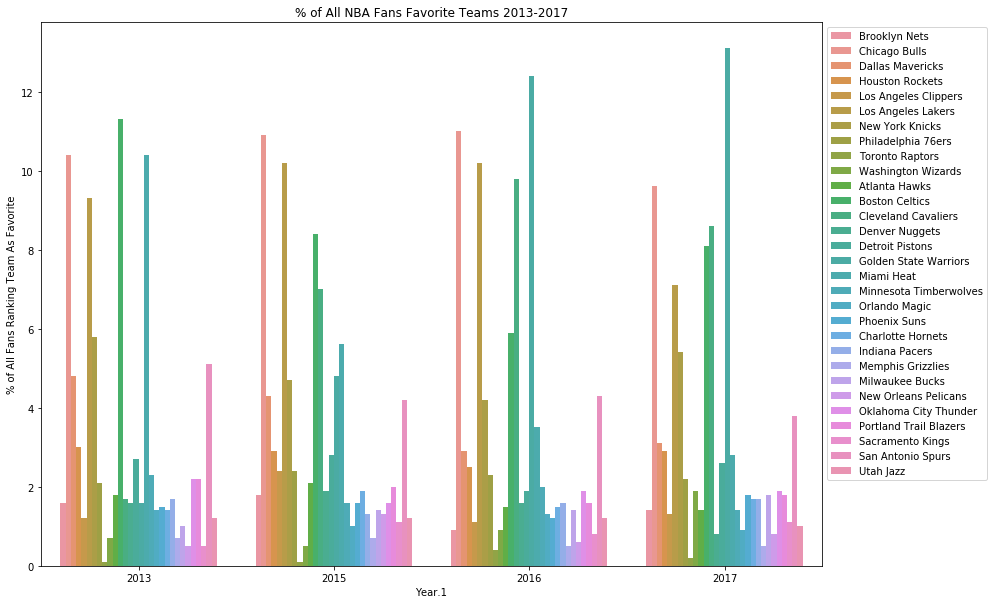

In [68]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
sns.barplot(x="Year.1", y="% of All Fans Ranking Team As Favorite", data=fav_df2.reset_index(), hue="Year")
plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.title('% of All NBA Fans Favorite Teams 2013-2017')

In [69]:
df_2 = 'FavTeamPerc3.csv'
ftp_df2 = pd.read_csv(df_2, low_memory=False)

ftp_df2 = ftp_df2[['Market_size','Year']].drop_duplicates()

ftp_df2.head()

,Market_size,Year
0,Big,New York Knicks
4,Big,Brooklyn Nets
8,Big,Los Angeles Lakers
12,Big,Los Angeles Clippers
16,Big,Chicago Bulls


In [70]:
fav_df_modified= fav_df.merge(ftp_df2,how = 'left',on = 'Year')
bigDF = fav_df_modified.loc[fav_df_modified.Market_size == "Big"].drop(columns = 'Market_size')
midDF = fav_df_modified.loc[fav_df_modified.Market_size == "Mid"].drop(columns = 'Market_size')
smallDF = fav_df_modified.loc[fav_df_modified.Market_size == "Small"].drop(columns = 'Market_size')

([<matplotlib.axis.XTick at 0x1c0f04b048>,
 <a list of 4 Text xticklabel objects>)

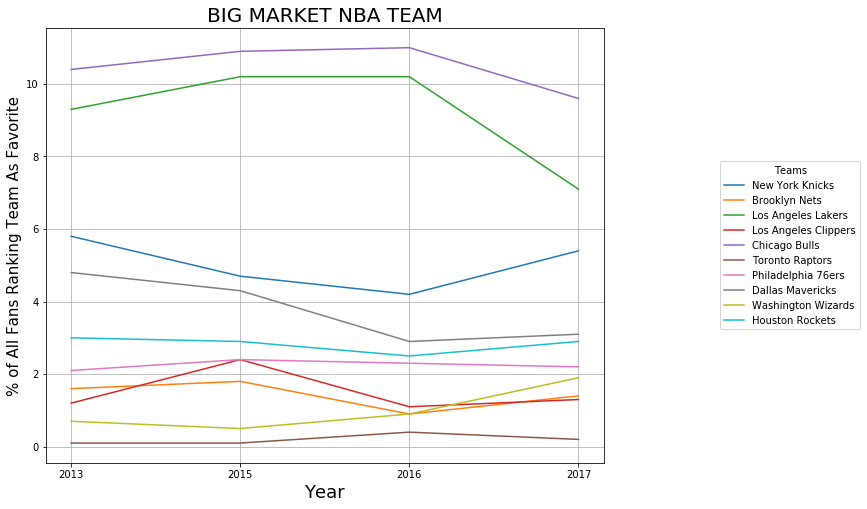

In [71]:
dfTransposed = bigDF.set_index("Year").T


dfTransposed.index

dfTransposed.reset_index(inplace = True)

dfTransposed['index']

my_xticks = dfTransposed['index']
dfTransposed.plot()
plt.grid()

plt.legend(loc = "center left" , bbox_to_anchor = (1.2, .5) , title = "Teams")
plt.title("BIG MARKET NBA TEAM" , size = 20)
plt.xlabel("Year", size = 18)
plt.ylabel("% of All Fans Ranking Team As Favorite" , size = 15)
plt.gcf().set_size_inches(10 , 8 , forward = True)
plt.xticks(dfTransposed.index,my_xticks)

([<matplotlib.axis.XTick at 0x1c0ef7b9e8>,
 <a list of 4 Text xticklabel objects>)

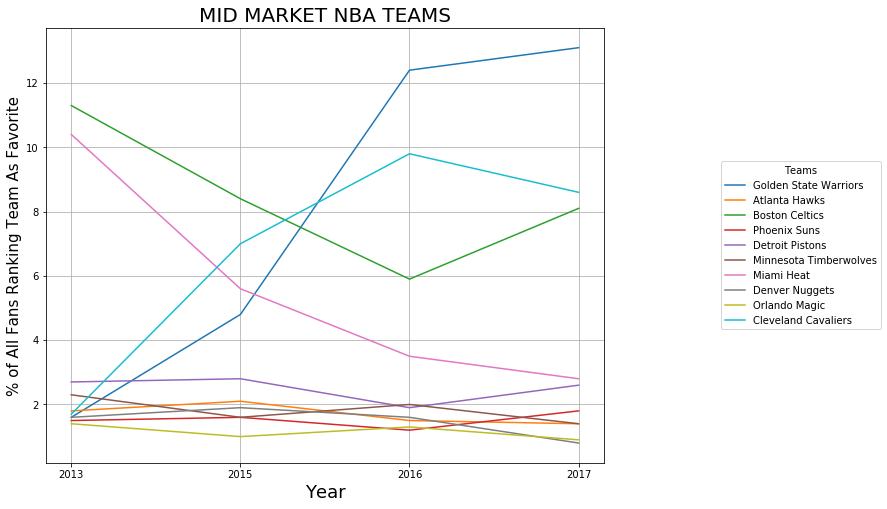

In [72]:
dfTransposed = midDF.set_index("Year").T


dfTransposed.index

dfTransposed.reset_index(inplace = True)

dfTransposed['index']

my_xticks = dfTransposed['index']
dfTransposed.plot()
plt.grid()

plt.legend(loc = "center left" , bbox_to_anchor = (1.2, .5) , title = "Teams")
plt.title("MID MARKET NBA TEAMS" , size = 20)
plt.xlabel("Year", size = 18)
plt.ylabel("% of All Fans Ranking Team As Favorite" , size = 15)
plt.gcf().set_size_inches(10 , 8 , forward = True)
plt.xticks(dfTransposed.index,my_xticks)

([<matplotlib.axis.XTick at 0x1c0efc1748>,
 <a list of 4 Text xticklabel objects>)

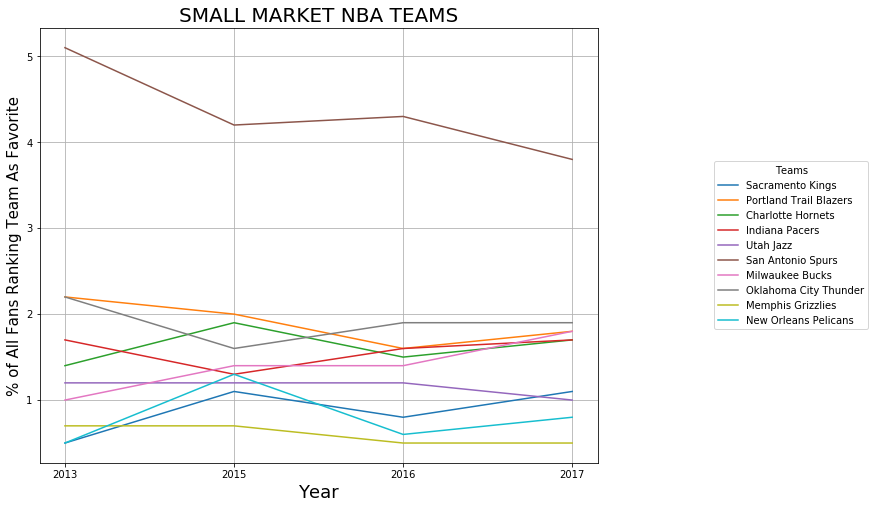

In [73]:
dfTransposed = smallDF.set_index("Year").T


dfTransposed.index

dfTransposed.reset_index(inplace = True)

dfTransposed['index']

my_xticks = dfTransposed['index']
dfTransposed.plot()
plt.grid()

plt.legend(loc = "center left" , bbox_to_anchor = (1.2, .5) , title = "Teams")
plt.title("SMALL MARKET NBA TEAMS" , size = 20)
plt.xlabel("Year", size = 18)
plt.ylabel("% of All Fans Ranking Team As Favorite" , size = 15)
plt.gcf().set_size_inches(10 , 8 , forward = True)
plt.xticks(dfTransposed.index,my_xticks)

([<matplotlib.axis.XTick at 0x1c0f03f550>,
 <a list of 4 Text xticklabel objects>)

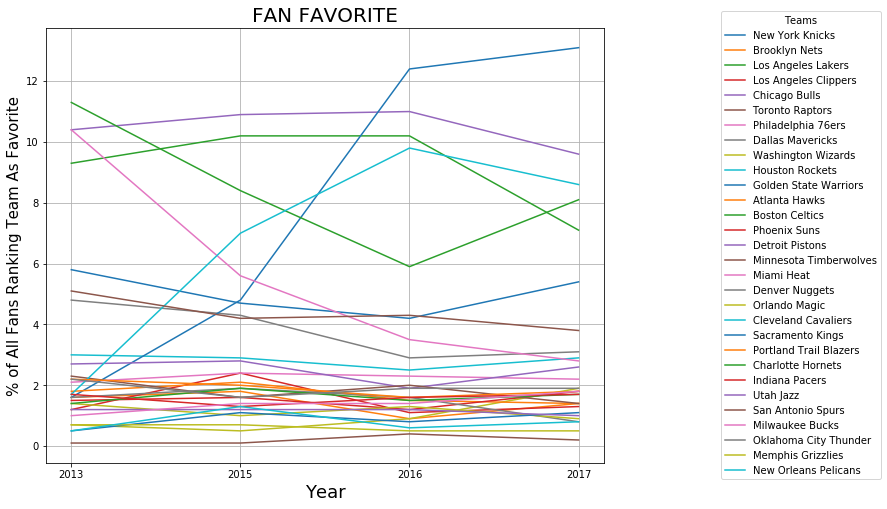

In [74]:
dfTransposed = fav_df.set_index("Year").T


dfTransposed.index

dfTransposed.reset_index(inplace = True)

dfTransposed['index']

my_xticks = dfTransposed['index']
dfTransposed.plot()
plt.grid()

plt.legend(loc = "center left" , bbox_to_anchor = (1.2, .5) , title = "Teams")
plt.title("FAN FAVORITE" , size = 20)
plt.xlabel("Year", size = 18)
plt.ylabel("% of All Fans Ranking Team As Favorite" , size = 15)
plt.gcf().set_size_inches(10 , 8 , forward = True)
plt.xticks(dfTransposed.index,my_xticks)

In [75]:
FavTeam = pd.read_csv("FavTeamPerc3.csv")
FavTeam.head()

,Market_size,Market_rank,Year,Year.1,% of All Fans Ranking Team As Favorite
0,Big,1,New York Knicks,2013,5.8
1,Big,1,New York Knicks,2015,4.7
2,Big,1,New York Knicks,2016,4.2
3,Big,1,New York Knicks,2017,5.4
4,Big,2,Brooklyn Nets,2013,1.6


In [76]:
big_filter = FavTeam[FavTeam['Market_rank'] <= 10]
big_filter.head()

,Market_size,Market_rank,Year,Year.1,% of All Fans Ranking Team As Favorite
0,Big,1,New York Knicks,2013,5.8
1,Big,1,New York Knicks,2015,4.7
2,Big,1,New York Knicks,2016,4.2
3,Big,1,New York Knicks,2017,5.4
4,Big,2,Brooklyn Nets,2013,1.6


In [77]:
mid_filter = FavTeam[(FavTeam['Market_rank'] >10) & (FavTeam['Market_rank'] <=20 )]
mid_filter.head()

,Market_size,Market_rank,Year,Year.1,% of All Fans Ranking Team As Favorite
40,Mid,11,Golden State Warriors,2013,1.6
41,Mid,11,Golden State Warriors,2015,4.8
42,Mid,11,Golden State Warriors,2016,12.4
43,Mid,11,Golden State Warriors,2017,13.1
44,Mid,12,Atlanta Hawks,2013,1.8


In [78]:
sml_filter = FavTeam[(FavTeam['Market_rank'] >20) & (FavTeam['Market_rank'] <=30 )]
sml_filter.head()

,Market_size,Market_rank,Year,Year.1,% of All Fans Ranking Team As Favorite
80,Small,21,Sacramento Kings,2013,0.5
81,Small,21,Sacramento Kings,2015,1.1
82,Small,21,Sacramento Kings,2016,0.8
83,Small,21,Sacramento Kings,2017,1.1
84,Small,22,Portland Trail Blazers,2013,2.2


In [79]:
BigM   = FavTeam[FavTeam["Market_size"] == "Big"]["% of All Fans Ranking Team As Favorite"]
MidM   = FavTeam[FavTeam["Market_size"] == "Mid"]["% of All Fans Ranking Team As Favorite"]
SmallM = FavTeam[FavTeam["Market_size"] == "Small"]["% of All Fans Ranking Team As Favorite"]

ANOVA_Test = stats.f_oneway(BigM , MidM , SmallM)
ANOVA_Test

F_onewayResult(statistic=7.658146276849183, pvalue=0.00074902011293344)

## <font color = Green> Results: Market Size vs Fan Favorites



> ### Market Size Fan Favorites ANOVA Result:  pvalue=0.00074902011293344 
>#### Interpretation: 
$<$ .05:  Reject Null Hypothesis H0
>>There is a difference in terms of being fan favorites across the 3 groups


## <font color = Red> Conclusions
***
- There is no visible correlation between population (census data) and team valuation.
- From the scatter plot, it looks like there is some correlation between per capita income and team valuations; however, we do not have enough evidence to make a conclusion.
- There is a correlation between median city rent and team valuation.
- In terms of valuation, being in a big market is more advantageous than being in a small or mid market. 
- In terms of social media following and polarity sentiments, big market teams have higher number of followers but not necessarily higher the sentiment scores.
- In terms of attendance, big market teams have a higher number of attendance than the mid and small market teams.
- In terms of win%, there is no difference across the 3 markets
- In terms of being fans favorite team, big market teams also have an advantage over the small and mid market teams
- Limitation of our analysis: 
    1. limited data source
    2. incomplete census data 
    3. Twitter was the only social media source
    4. The way we divided up the market size rank is not truly representative of actual market size rank.
       - there are more big market teams than small and mid market teams (not 10/10/10)
    5. ANOVA analysis doesn't work well with time series data
   